<a href="https://colab.research.google.com/github/Gholamrezadar/facial_keypoints_detection/blob/main/Facial_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoints Detection
By Gholamreza Dar June 2024

In [ ]:
!pip install -q timm torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import timm
from torchsummary import summary

In [ ]:
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# random seed
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

## Download data

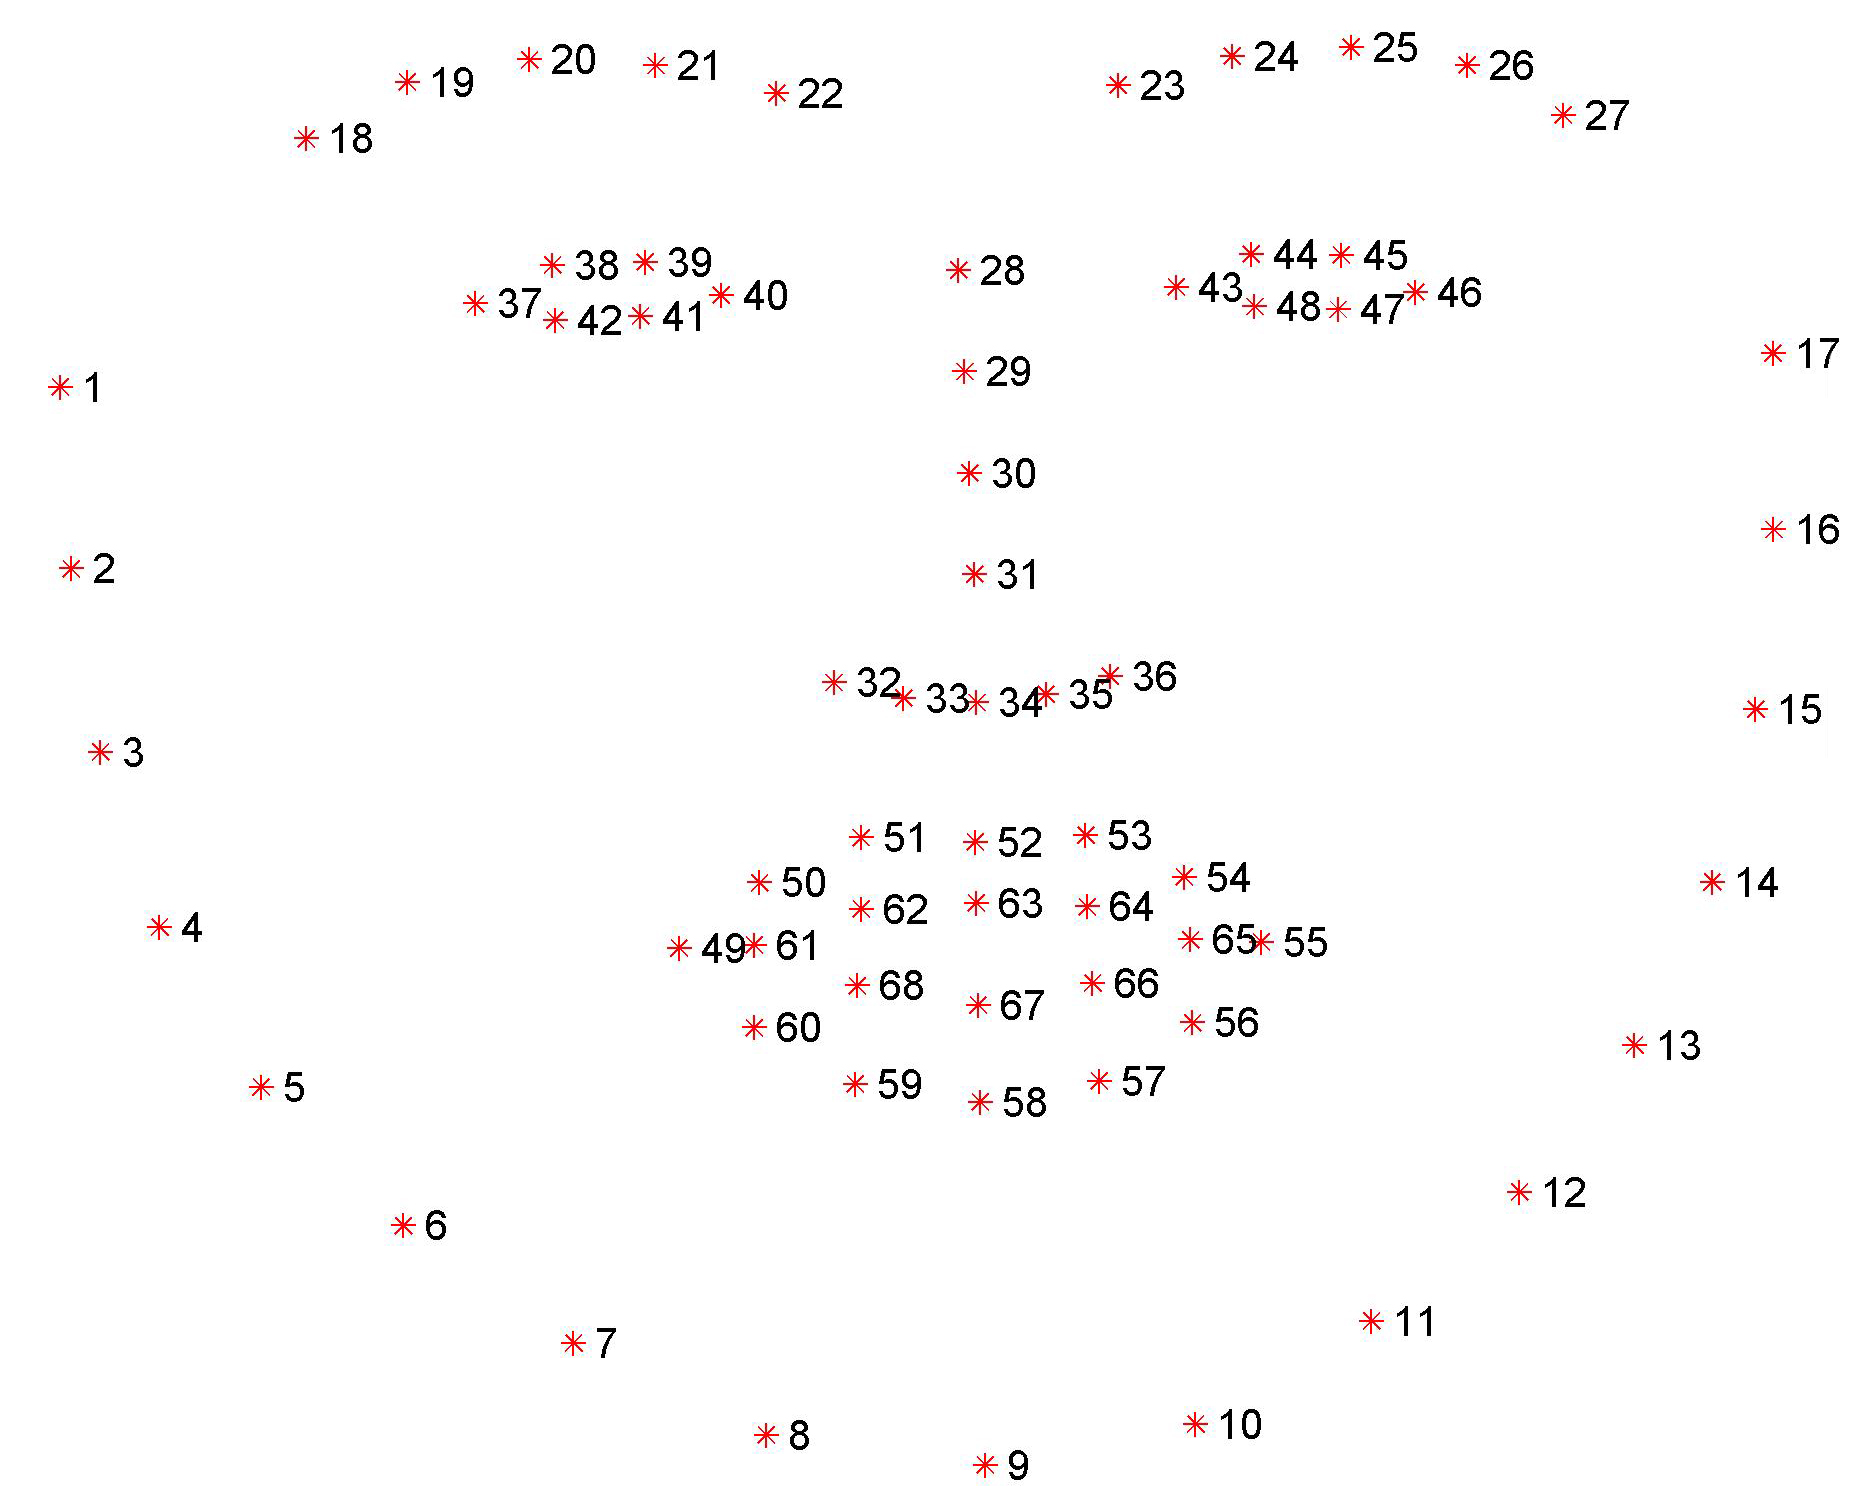

In [ ]:
!curl -L https://huggingface.co/datasets/Gholamreza/facial-keypoints/resolve/main/train-test-data.zip --output train-test-data.zip
!unzip -n train-test-data.zip -d data
!rm train-test-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_21.jpg  
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  

## Dataset and DataLoader

In [ ]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, images_root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_root_dir = images_root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_root_dir, self.data.iloc[idx, 0])
        image = Image.open(image_path)
        original_height, original_width = image.size

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image))

        # if image is rgba convert to rgb
        if(image.shape[0] == 4): # 0 because B,W,H
            image = image[0:3,:,:]

        keypoints = torch.tensor(self.data.iloc[idx, 1:].astype('float32').values, dtype=torch.float32)

        # normalize keypoint positions
        keypoints = keypoints.reshape(-1, 2)
        keypoints = keypoints / torch.tensor([original_height, original_width])

        # flatten again
        keypoints = keypoints.flatten()

        # keypoints /= 100.0

        return image, keypoints

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = FacialKeypointsDataset(csv_file="data/training_frames_keypoints.csv", images_root_dir="data/training", transform=transform)
test_dataset = FacialKeypointsDataset(csv_file="data/test_frames_keypoints.csv", images_root_dir="data/test", transform=transform)

In [ ]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 3462
Number of test samples: 770


In [ ]:
# create a subset of the dataset
DATASET_LENGTH = 100000
train_dataset = torch.utils.data.Subset(train_dataset, range(min(len(train_dataset), DATASET_LENGTH)))
test_dataset = torch.utils.data.Subset(test_dataset, range(min(len(test_dataset), DATASET_LENGTH)))

In [ ]:
print(f"Number of selected training samples: {len(train_dataset)}")
print(f"Number of selected test samples: {len(test_dataset)}")

Number of selected training samples: 3462
Number of selected test samples: 770


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### a few samples

In [ ]:
# a function to display the keypoints on top of the image
def show_keypoints(image, keypoints, figsize=(2,2), save=False, name="a.png"):
    plt.figure(figsize=figsize)
    plt.tight_layout()
    plt.imshow(image.permute(1, 2, 0))
    keypoints = keypoints.reshape((-1, 2))
    keypoints = keypoints * 224
    keypoints = keypoints.to(torch.int32)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='g')
    plt.axis('off')
    plt.xlim(0, 224)
    plt.ylim(224, 0)

    if save:
      plt.savefig(name)

    plt.show()

In [ ]:
image, keypoints = next(iter(train_dataloader))
keypoints.min().item(), keypoints.max().item()

(0.19463087618350983, 0.7722772359848022)

In [ ]:
image.shape, keypoints.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 136]))

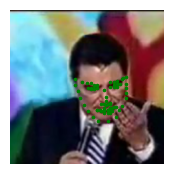

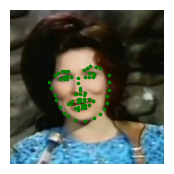

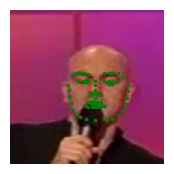

In [ ]:
idx = 3
show_keypoints(image[idx], keypoints[idx])
idx = 4
show_keypoints(image[idx], keypoints[idx])
idx = 5
show_keypoints(image[idx], keypoints[idx])

## Model

In [ ]:
class Model_Pretrained_CNN_MLP(nn.Module):
    def __init__(self, head_hidden_size=512, dropout_rate=0.3):
        super(Model_Pretrained_CNN_MLP, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        backbone_clf_in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.dropout_rate = dropout_rate

        backbone_output_size = backbone_clf_in_features
        head_hidden_size = head_hidden_size
        output_size = 136 # 68 points with 2 coordinates each

        self.head = nn.Sequential(
            nn.Linear(backbone_output_size, head_hidden_size),
            # nn.BatchNorm1d(head_hidden_size),
            nn.ReLU(),
            # nn.Dropout(self.dropout_rate),
            nn.Linear(head_hidden_size, output_size)
        )

    def forward(self, x):
        # import pdb; pdb.set_trace()
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [ ]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=1024).to(device)

# freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

## Training

In [ ]:
from tqdm.auto import tqdm

def train(model, train_loader, optimizer, criterion, running_loss, epoch):
    loss_history = []
    model.train()

    i = 0
    for (X, y) in (pbar := tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 136)) # 68 keypoints * 2
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * BATCH_SIZE

        loss_history.append(running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE))
        pbar.set_description(f"Batch {i}/{len(train_loader)} Loss: {running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE)}")

        # if i%5 == 0:
        #     visualize_prediction(model, test_dataset[0], save=True, name=f"animation/face_animation_{epoch}_{i//5:0>3}.png")
        #     plt.show()

        i += 1

    return running_loss,  loss_history

def train_1_batch(model, train_loader, optimizer, criterion, running_loss, epoch):
    loss_history = []
    model.train()

    X, y = next(iter(train_loader))

    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y.view(-1, 136)) # 68 keypoints * 2
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * BATCH_SIZE

    # loss_history.append(running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE))

    # if i%5 == 0:
    #     visualize_prediction(model, test_dataset[0])
    #     plt.show()


    return running_loss,  loss_history

def evaluate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.inference_mode():
      for i, (X, y) in enumerate(valid_loader):
          X, y = X.to(device), y.to(device)
          y_pred = model(X)
          loss = criterion(y_pred, y.view(-1, 136))
          running_loss += loss.item()
    return running_loss / len(valid_loader)


def predict(model, sample):
    X, y = sample
    model.eval()
    with torch.inference_mode():
        y_pred = model(X.unsqueeze(0).to(device))
    return y_pred.cpu()

def visualize_prediction(model, sample, save=False, name="a.png"):
    X, y = sample
    y_pred = predict(model, sample)
    show_keypoints(X, y_pred[0], save=save, name=name)


### Start Training

#### Step 1) Overfit on 1 batch

In [ ]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=512).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 30

Epoch 1/30
train_loss: 0.041730987174170356 | Valid Loss: 0.0000

Epoch 2/30
train_loss: 0.033813495721135824 | Valid Loss: 0.0000

Epoch 3/30
train_loss: 0.02619634462254388 | Valid Loss: 0.0000

Epoch 4/30
train_loss: 0.02482503785618714 | Valid Loss: 0.0000

Epoch 5/30
train_loss: 0.0220774524978229 | Valid Loss: 0.0000

Epoch 6/30
train_loss: 0.020537117230040685 | Valid Loss: 0.0000

Epoch 7/30
train_loss: 0.01874203729082127 | Valid Loss: 0.0000

Epoch 8/30
train_loss: 0.017999425730002776 | Valid Loss: 0.0000

Epoch 9/30
train_loss: 0.01722131356123894 | Valid Loss: 0.0000

Epoch 10/30
train_loss: 0.016841841329421316 | Valid Loss: 0.0000

Epoch 11/30
train_loss: 0.016448295590552418 | Valid Loss: 0.0000

Epoch 12/30
train_loss: 0.015907836235350088 | Valid Loss: 0.0000

Epoch 13/30
train_loss: 0.015439981410464088 | Valid Loss: 0.0000

Epoch 14/30
train_loss: 0.015089436415202764 | Valid Loss: 0.0000

Epoch 15/30
train_loss: 0.014470512561854863 | Valid Loss: 0.0000

Epoch 16/3

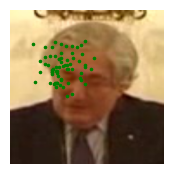

In [ ]:
loss_history_global = []
train_loss = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, history = train_1_batch(model, train_dataloader, optimizer, criterion, train_loss, epoch)
    # valid_loss = evaluate(model, test_dataloader, criterion)
    valid_loss = 0
    loss_history_global = loss_history_global + history
    print(f"train_loss: {train_loss/((epoch+1)*len(train_dataloader)*BATCH_SIZE)} | Valid Loss: {valid_loss:.4f}")
    print()
    plt.show()
visualize_prediction(model, test_dataset[0])

YES! Overfits!

#### Step 2) Actual Training

In [ ]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=1024).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 20

In [ ]:
torch.__version__

'2.3.0+cu121'

Epoch 1/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.010779400585725697 | Valid Loss: 0.0028


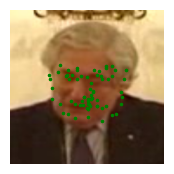



Epoch 2/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.00615664276300848 | Valid Loss: 0.0009


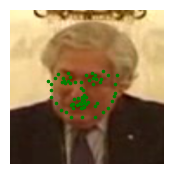



Epoch 3/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.004428362085839115 | Valid Loss: 0.0007


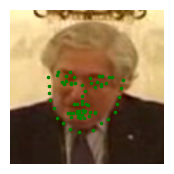



Epoch 4/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0034815259934668557 | Valid Loss: 0.0005


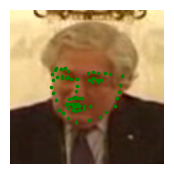



Epoch 5/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.002890269079407643 | Valid Loss: 0.0004


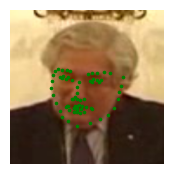



Epoch 6/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.002477045267372043 | Valid Loss: 0.0002


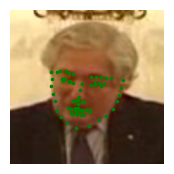



Epoch 7/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0021772188813478635 | Valid Loss: 0.0009


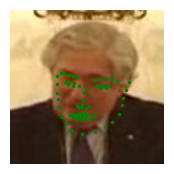



Epoch 8/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.00195242664152586 | Valid Loss: 0.0005


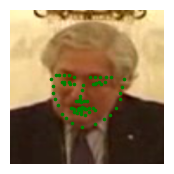



Epoch 9/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.00176879406127552 | Valid Loss: 0.0003


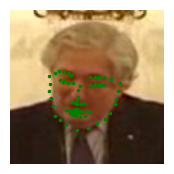



Epoch 10/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0016162111858958282 | Valid Loss: 0.0002


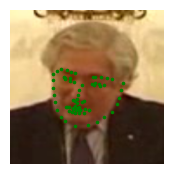



Epoch 11/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0014928305790101514 | Valid Loss: 0.0003


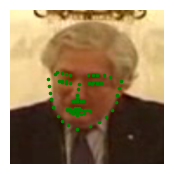



Epoch 12/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0013880891618326904 | Valid Loss: 0.0002


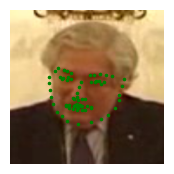



Epoch 13/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0012976995169185763 | Valid Loss: 0.0002


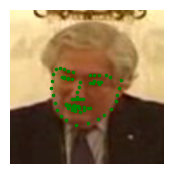



Epoch 14/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.001221403968040029 | Valid Loss: 0.0002


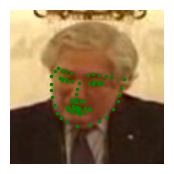



Epoch 15/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0011551295850849238 | Valid Loss: 0.0002


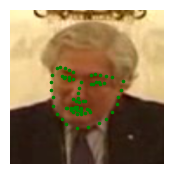



Epoch 16/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0011947885585981953 | Valid Loss: 0.0010


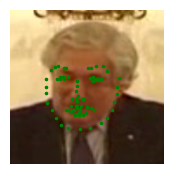



Epoch 17/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0011750700636220276 | Valid Loss: 0.0007


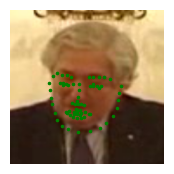



Epoch 18/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0011365602669816705 | Valid Loss: 0.0003


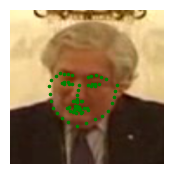



Epoch 19/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.001096342911867783 | Valid Loss: 0.0004


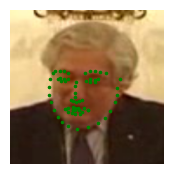



Epoch 20/20


  0%|          | 0/217 [00:00<?, ?it/s]

train_loss: 0.0010562130488098002 | Valid Loss: 0.0004


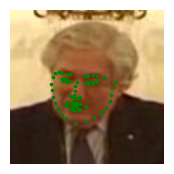

In [ ]:
loss_history_global = []
train_loss = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, history = train(model, train_dataloader, optimizer, criterion, train_loss, epoch)
    valid_loss = evaluate(model, test_dataloader, criterion)
    loss_history_global = loss_history_global + history
    print(f"train_loss: {train_loss/((epoch+1)*len(train_dataloader)*BATCH_SIZE)} | Valid Loss: {valid_loss:.4f}")
    visualize_prediction(model, test_dataset[0])
    plt.show()
    print()
    print()

In [ ]:
# !ffmpeg -framerate 10 -i animation/face_animation_0_%03d.png -vf "scale=640:-1:flags=lanczos" -pix_fmt rgb8 output.gif

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

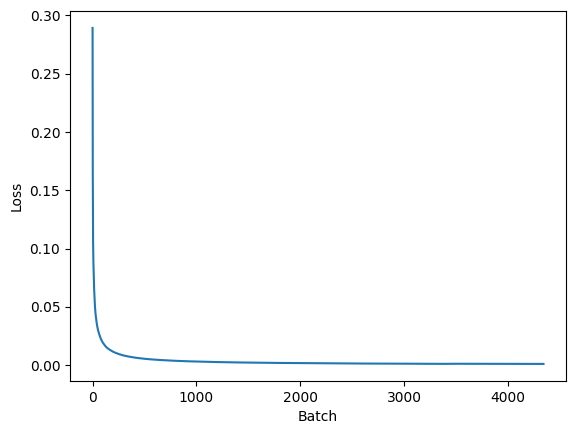

In [ ]:
plt.plot(loss_history_global)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [ ]:
 = next(iter(test_dataloader))

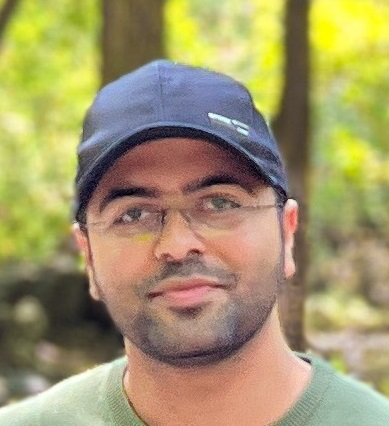

In [ ]:
img = Image.open('GHDface.jpg')
img

In [ ]:
transform(img)

tensor([[[0.6784, 0.6353, 0.5686,  ..., 0.8941, 0.8980, 0.8941],
         [0.6431, 0.5961, 0.5333,  ..., 0.9098, 0.9020, 0.8941],
         [0.6078, 0.5529, 0.4824,  ..., 0.9255, 0.9176, 0.9020],
         ...,
         [0.8549, 0.8471, 0.8392,  ..., 0.7020, 0.7059, 0.7176],
         [0.8392, 0.8235, 0.8196,  ..., 0.7059, 0.7137, 0.7176],
         [0.8118, 0.8157, 0.8118,  ..., 0.7098, 0.7176, 0.7137]],

        [[0.6902, 0.6353, 0.5490,  ..., 0.8627, 0.8627, 0.8627],
         [0.6510, 0.5922, 0.5059,  ..., 0.8745, 0.8745, 0.8706],
         [0.6039, 0.5412, 0.4510,  ..., 0.8980, 0.8941, 0.8824],
         ...,
         [0.9176, 0.9059, 0.8980,  ..., 0.8235, 0.8275, 0.8392],
         [0.9098, 0.8941, 0.8902,  ..., 0.8275, 0.8353, 0.8392],
         [0.8902, 0.8902, 0.8863,  ..., 0.8275, 0.8392, 0.8353]],

        [[0.2824, 0.2667, 0.2471,  ..., 0.3922, 0.3725, 0.3490],
         [0.2667, 0.2510, 0.2314,  ..., 0.3922, 0.3686, 0.3412],
         [0.2667, 0.2471, 0.2235,  ..., 0.3843, 0.3608, 0.

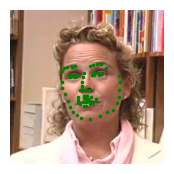

In [ ]:
idx = 2
X, y = (sample[0][idx], sample[1][idx])
visualize_prediction(model, sample=(X, y))

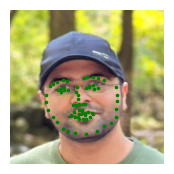

In [ ]:
X = transform(img)
visualize_prediction(model, sample=(X, y))